## Hate Speech and Abusive Language Detection in the Indonesian Twitter


## Install dan Import Library

In [14]:
!pip install sastrawi
import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Dataset

In [15]:
re_dataset = pd.read_csv("/content/re_dataset.csv", encoding='latin1')
new_kamusalay = pd.read_csv("/content/new_kamusalay.csv", encoding='latin1')
abusive_words = pd.read_csv("/content/abusive.csv", encoding='latin1')


## Exploratory Data Analysis (EDA)

In [16]:
# re_dataset
re_dataset.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0


In [17]:
# Shape dari re_dataset
print("Shape re_dataset:")
print(re_dataset.shape)

Shape re_dataset:
(13169, 13)


In [18]:
# Cek missing value di re_dataset
print("\nMissing values in re_dataset:")
print(re_dataset.isnull().sum())


Missing values in re_dataset:
Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64


In [19]:
# Value counts untuk setiap label di re_dataset
label_columns = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']
print("1 = Yes , 0 = No")
for label_column in label_columns:
    print(f"\nValue counts for {label_column}:")
    print(re_dataset[label_column].value_counts())

1 = Yes , 0 = No

Value counts for HS:
0    7608
1    5561
Name: HS, dtype: int64

Value counts for Abusive:
0    8126
1    5043
Name: Abusive, dtype: int64

Value counts for HS_Individual:
0    9594
1    3575
Name: HS_Individual, dtype: int64

Value counts for HS_Group:
0    11183
1     1986
Name: HS_Group, dtype: int64

Value counts for HS_Religion:
0    12376
1      793
Name: HS_Religion, dtype: int64

Value counts for HS_Race:
0    12603
1      566
Name: HS_Race, dtype: int64

Value counts for HS_Physical:
0    12846
1      323
Name: HS_Physical, dtype: int64

Value counts for HS_Gender:
0    12863
1      306
Name: HS_Gender, dtype: int64

Value counts for HS_Other:
0    9429
1    3740
Name: HS_Other, dtype: int64

Value counts for HS_Weak:
0    9786
1    3383
Name: HS_Weak, dtype: int64

Value counts for HS_Moderate:
0    11464
1     1705
Name: HS_Moderate, dtype: int64

Value counts for HS_Strong:
0    12696
1      473
Name: HS_Strong, dtype: int64


In [20]:
# new_kamusalay
new_kamusalay.head(10)

Shape new_kamusalay:
(15166, 2)


,anakjakartaasikasik,anak jakarta asyik asyik
0,pakcikdahtua,pak cik sudah tua
1,pakcikmudalagi,pak cik muda lagi
2,t3tapjokowi,tetap jokowi
3,3x,tiga kali
4,aamiin,amin
5,aamiinn,amin
6,aamin,amin
7,aammiin,amin
8,abis,habis
9,abisin,habiskan


In [41]:
print("Shape new_kamusalay:")
print(new_kamusalay.shape)

Shape new_kamusalay:
(15166, 2)


In [21]:
# abusive_words
abusive_words.head(10)

Shape abusive_words:
(125, 1)


,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing
5,anjir
6,babi
7,bacot
8,bajingan
9,banci


In [42]:
print("Shape abusive_words:")
print(abusive_words.shape)

Shape abusive_words:
(125, 1)


#### Visualisasi

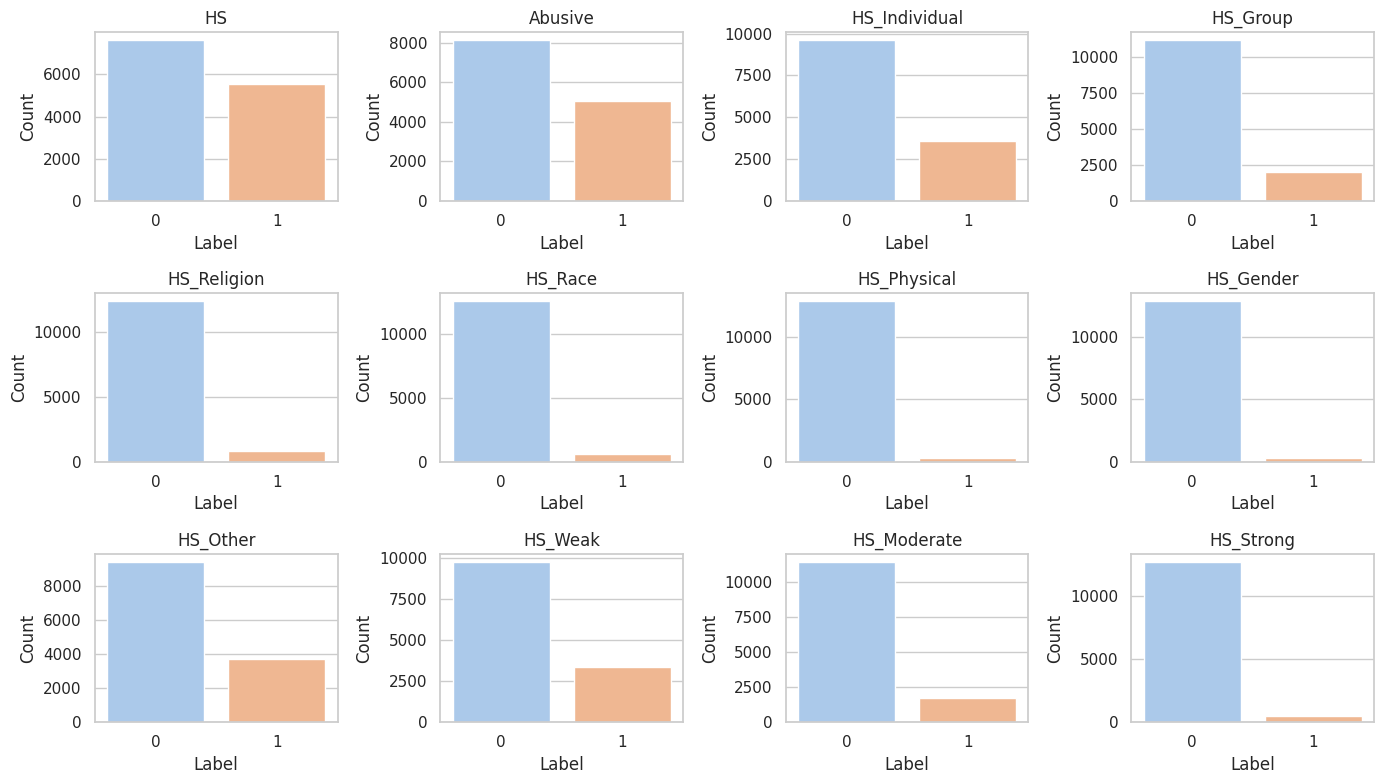

In [22]:
# Count Plot untuk setiap label pada "re_dataset"
sns.set(style="whitegrid")

label_columns = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']
plt.figure(figsize=(14, 8))
for i, label_column in enumerate(label_columns):
    plt.subplot(3, 4, i + 1)
    sns.countplot(x=label_column, data=re_dataset, palette="pastel")
    plt.title(f"{label_column}")
    plt.xlabel("Label")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

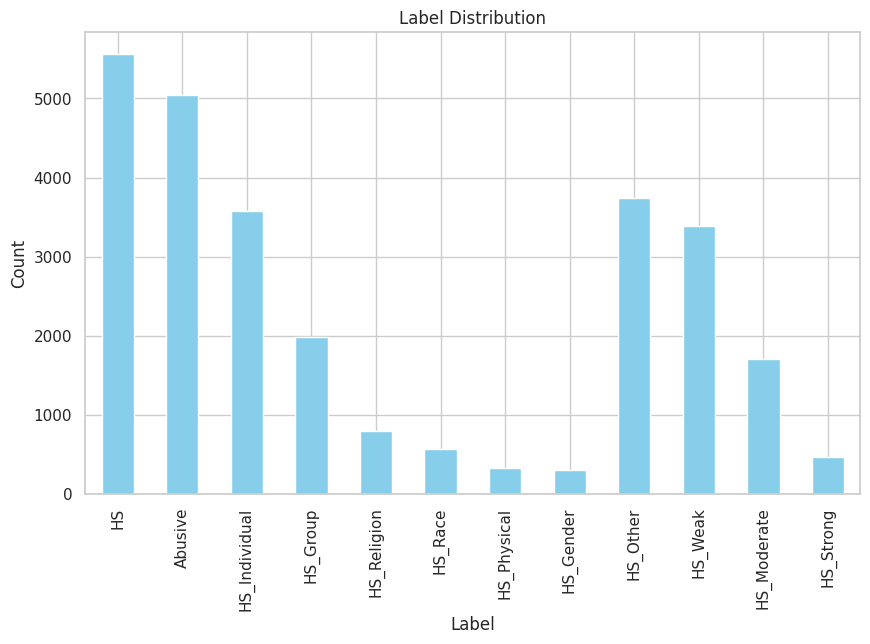

In [23]:
# Label Distribution dari "re_dataset"
plt.figure(figsize=(10, 6))
re_dataset[label_columns].sum().plot(kind='bar', color='skyblue')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

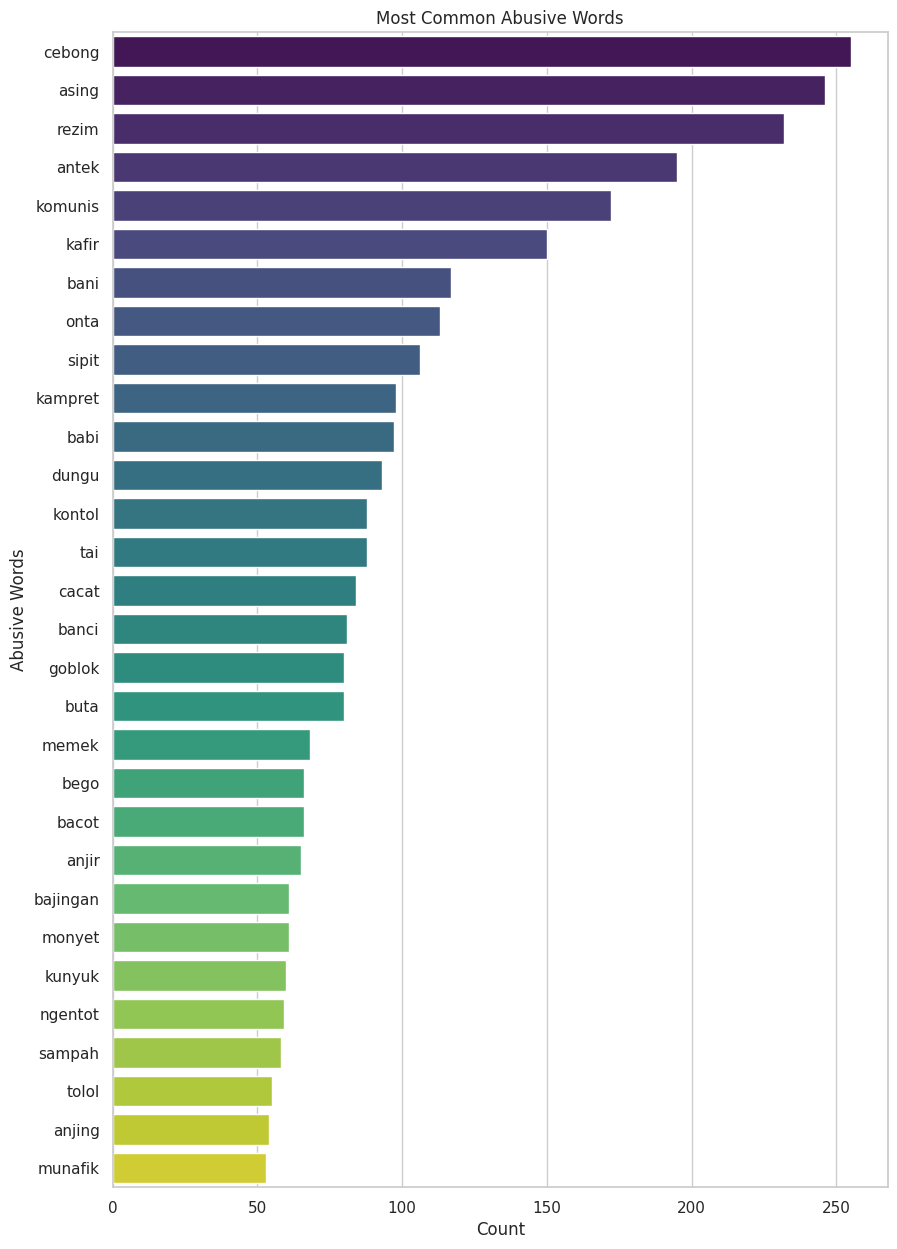

In [24]:
# Mengumpulkan kata "Abusive" yang paling banyak dipakai
abusive_corpus = []
for tweet in re_dataset['Tweet'].str.split():
    for word in tweet:
        if len(word) > 0 and word in abusive_words['ABUSIVE'].values:
            abusive_corpus.append(word)

counter_abusive = Counter(abusive_corpus).most_common()[:1000]
top_abusive = dict(counter_abusive)

show_only = 30

keys_abusive = list(top_abusive.keys())
vals_abusive = [top_abusive[k] for k in keys_abusive]

plt.figure(figsize=(10, 15))
sns.barplot(x=vals_abusive[:show_only], y=keys_abusive[:show_only], palette="viridis")
plt.title('Most Common Abusive Words')
plt.xlabel('Count')
plt.ylabel('Abusive Words')
plt.show()

## Pre-Processing

In [25]:
# Menampilkan nama kolom pada new_kamusalay
print(new_kamusalay.columns)

# Modifikasi fungsi normalize_alay
typo_dict_map = dict(zip(new_kamusalay['anakjakartaasikasik'], new_kamusalay['anak jakarta asyik asyik']))
def normalize_alay(text):
    return ' '.join([typo_dict_map[word] if word in typo_dict_map else word for word in text.split(' ')])


Index(['anakjakartaasikasik', 'anak jakarta asyik asyik'], dtype='object')


In [26]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Inisialisasi stopword remover
stopword_factory = StopWordRemoverFactory()
id_stopword_dict = stopword_factory.get_stop_words()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text)
    text = re.sub('rt', ' ', text)
    text = re.sub('user', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

typo_dict_map = dict(zip(new_kamusalay['anakjakartaasikasik'], new_kamusalay['anak jakarta asyik asyik']))
def normalize_alay(text):
    return ' '.join([typo_dict_map[word] if word in typo_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    return text

re_dataset['Tweet'] = re_dataset['Tweet'].apply(preprocess)
print("Shape: ", re_dataset.shape)
print(re_dataset.head(15))


Shape:  (13169, 13)
                                                Tweet  HS  Abusive  \
0   semua cowok usaha lacak perhati gue kamu lanta...   1        1   
1   siapa telat beri tau kamu edan sarap gue gaul ...   0        1   
2   41 kadang aku pikir aku tetap percaya tuhan pa...   0        0   
3            aku aku ku tau mata sipit lihat mana aku   0        0   
4   kaum cebong kafir lihat dongok awal tambah dun...   1        1   
5   bani taplak kawan kawan xf0 x9f x98 x84 xf0 x9...   1        1   
6   deklarasi pilih kepala daerah 2018 aman anti h...   0        0   
7   gue baru selesai re watch aldnoah zero paling ...   0        1   
8   nah admin belanja satu po baik nak makan ais k...   0        0   
9                                    enak kalau ngewe   0        1   
10  gue punya jari tengah buat kamu gue ukur nyali...   1        1   
11  banci kaleng malu jawab pe anyaan 2 hari lalu ...   1        1   
12  kalau ajar ekonomi mesti jago privatisasi hati...   0        0   


## Model

In [38]:
def build_model(data, category, vectorizer, ngram):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    vector = vectorizer(ngram_range=ngram, stop_words=id_stopword_dict)

    X_train_scal = vector.fit_transform(X_train)
    X_test_scal = vector.transform(X_test)

    # Logistic Regression
    lr = LogisticRegression()
    lr.fit(X_train_scal, Y_train)

    return lr, X_test_scal, Y_test

label_list = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']

models = {}

for label in label_list:
    lr_model, X_test, Y_test = build_model(re_dataset, label, TfidfVectorizer, (1, 1))
    models[label] = {'model': lr_model, 'X_test': X_test, 'Y_test': Y_test}


## Evaluasi Model

In [39]:
def evaluate_model(model, X_test, Y_test, category):
    Y_pred = model.predict(X_test)

    print(f"Evaluation for {category}:\n {classification_report(Y_test, Y_pred)} ")

    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    print(f"Accuracy for {category}: {accuracy}")
    print(f"Precision for {category}: {precision}")
    print(f"Recall for {category}: {recall}")
    print(f"F1-Score for {category}: {f1}\n")

label_list = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']

for label in label_list:
    data_label = re_dataset[[label, 'Tweet']]
    model, X_test, Y_test = build_model(data_label, label, TfidfVectorizer, (1, 1))
    evaluate_model(model, X_test, Y_test, label)


Evaluation for HS:
               precision    recall  f1-score   support

           0       0.83      0.91      0.86      2301
           1       0.85      0.73      0.79      1650

    accuracy                           0.83      3951
   macro avg       0.84      0.82      0.82      3951
weighted avg       0.83      0.83      0.83      3951
 
Accuracy for HS: 0.8334598835737788
Precision for HS: 0.8346811081255425
Recall for HS: 0.8334598835737788
F1-Score for HS: 0.8312861307085228

Evaluation for Abusive:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2440
           1       0.92      0.78      0.85      1511

    accuracy                           0.89      3951
   macro avg       0.90      0.87      0.88      3951
weighted avg       0.89      0.89      0.89      3951
 
Accuracy for Abusive: 0.891672994178689
Precision for Abusive: 0.8941175645807384
Recall for Abusive: 0.891672994178689
F1-Score for Abusive: 0.88971389830

## Prediksi Menggunakan Model

In [40]:
def train_and_predict(data, category, vectorizer, ngram, example1, example2):
    X = data['Tweet'].fillna(' ')
    Y = data[category]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    vector = vectorizer(ngram_range=ngram)  # Tidak menggunakan stop_words karena Sastrawi sudah memiliki stopword
    x_train_scal = vector.fit_transform(x_train)
    x_test_scal = vector.transform(x_test)

    model = LogisticRegression()
    model.fit(x_train_scal, y_train)

    example1_preprocessed = [preprocess(text) for text in example1]
    example2_preprocessed = [preprocess(text) for text in example2]

    example1_transform = vector.transform(example1_preprocessed)
    example2_transform = vector.transform(example2_preprocessed)

    prediction1 = model.predict(example1_transform)
    prediction2 = model.predict(example2_transform)

    return prediction1, prediction2

label_list = ['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']

for label in label_list:
    data_label = re_dataset[[label, 'Tweet']]
    input1 = ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing']
    input2 = ['Kamu keren Saka, kerja bagus']
    predictions = train_and_predict(data_label, label, TfidfVectorizer, (1, 1), input1, input2)

    print(f"\nPredictions for {label}:\n")
    print(f"Input 1: {input1} = {'not' if predictions[0] == 0 else ''} {label} / {predictions[0]}")
    print(f"Input 2: {input2} = {'not' if predictions[1] == 0 else ''} {label} / {predictions[1]}\n")



Predictions for HS:

Input 1: ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing'] =  HS / [1]
Input 2: ['Kamu keren Saka, kerja bagus'] = not HS / [0]


Predictions for Abusive:

Input 1: ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing'] =  Abusive / [1]
Input 2: ['Kamu keren Saka, kerja bagus'] = not Abusive / [0]


Predictions for HS_Individual:

Input 1: ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing'] =  HS_Individual / [1]
Input 2: ['Kamu keren Saka, kerja bagus'] = not HS_Individual / [0]


Predictions for HS_Group:

Input 1: ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing'] = not HS_Group / [0]
Input 2: ['Kamu keren Saka, kerja bagus'] = not HS_Group / [0]


Predictions for HS_Religion:

Input 1: ['Goblok, dasar SAKA tolol, jadi orang tu jangan idiot lah, anjing'] = not HS_Religion / [0]
Input 2: ['Kamu keren Saka, kerja bagus'] = not HS_Religion / [0]


Predictions for HS_Race:

Input 1: ['Goblok, dasar